# Logistic Regression

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit, softmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.inspection import DecisionBoundaryDisplay
from numpy.testing import assert_array_almost_equal, assert_equal

# Theory

## Assumptions & Model Specification
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space and assume that $X$ is a $d$-dimensional random variable modelling our features and $Y$ is a categorial random variable modelling our response, i.e. $Y$ can only take finitely many values $\{0, 1, \ldots, K-1\}$. 

**Assumption:** Logistic regression assumes that the (normalized) log-likelihood of the conditional class probabilities $\mathbb{P}[Y=k \mid X=x]$ is affine linear, i.e. we assume that there exists $\theta=(\alpha_k, \beta_k)_{0 \leq k \leq K-1}$, $\beta_k \in \mathbb{R}^d$ and $\alpha_k \in \mathbb{R}$ such that
\begin{align}
    \label{EqLogReg}
    \forall 0 \leq k \leq K-1: \log\Big(\frac{\mathbb{P}[Y=k \mid X=x]}{w_k(x; \theta)}\Big) = \alpha_k + \beta_k^\top x,
\end{align}
where $w_k(x; \theta) \in \mathbb{R}_{>0}$ are any normalization constants such that the resulting probabilities
\begin{align}
    \forall 0 \leq k \leq K-1: \mathbb{P}[Y=k \mid X=x] = w_k(x; \theta) e^{\alpha_k + \beta_k^\top x} =:p_{\theta}(k|x)
\end{align}
sum to one, i.e.
\begin{align*}
    1 = \sum_{k=0}^{K-1}{p_{\theta}(k \mid x)} = \sum_{k=0}^{K-1}{w_k(x; \theta) e^{\alpha_k + \beta_k^{\top}x}}.
\end{align*}

## Flavours of Logistic Regression
There exist various flavours of the above model formulation of logistic regression. We generally decide between the *binary case*, sometimes called *Bernoulli logistic regression*, in which we only have two classes, i.e. $K=2$, and the *multi class case*, sometimes called *multinomial logistic regression*, in which we allow $K>2$. In order to ensure that all probabilities sum to one, different choices of normalization constants lead to slightly different equations. We describe some popular formulations in the following. 

### Binary case (Bernoulli logistic regression)
In the binary case, one typically sets the normalization constant to be equal to the conditional probability of one particular class, for example $k=0$, i.e.
\begin{align*}
    \forall 1 \leq k \leq K-1: w_k(x; \theta) := p_{\theta}(0 \mid x)
\end{align*}
and then we drop the resulting equation for $k=0$ from the model (because it would always imply $\alpha_0=0$, $\beta_0=0$). 

Notice that this constant can be easily calculated: By construction 
\begin{align*}
    p_{\theta}(0 \mid x)
    = 1 - \sum_{k=1}^{K-1}{p_{\theta}(k \mid x)}
    = 1 - p_{\theta}(0 \mid x) \sum_{k=1}^{K-1}{e^{\alpha_k + \beta_k^{\top}x}},
\end{align*}
hence
\begin{align*}
    1 =  \Big(1 +  \sum_{k=1}^{K-1}{e^{\alpha_k + \beta_k^{\top}x}}\Big) p_{\theta}(0 \mid x)
    \; \Longleftrightarrow \;
    p_{\theta}(0 \mid x) = \frac{1}{1 +  \sum_{k=1}^{K-1}{e^{\alpha_k + \beta_k^{\top}x}}}.
\end{align*}
This choice of normalization constant and model specification is popular for the [binary case](https://scikit-learn.org/stable/modules/linear_model.html#binary-case), but could be used in the multi-class case as well (with any class $k$ singled out for normalization). 

Notice that in this case, the parameter set collapses to $\theta=(\alpha_1, \beta_1)=:(\alpha,\beta)$ because the equation for $k=0$ has been dropped from the model and the model is then only defined in terms of $p_{\theta}(1 \mid x)$, the success class probability, and the above normalization constant $p_{\theta}(0 \mid x)$, the failure class probability:
\begin{align*}
    p_{\theta}(1 \mid x) & = w_1(x; \theta) e^{\alpha + \beta^\top x} = p_\theta(0 \mid x) e^{\alpha + \beta^\top x} \\
    p_{\theta}(0 \mid x) &= \frac{1}{1 + e^{\alpha + \beta^{\top}x}}.
\end{align*}


#### Sigmoid and Logit function 
These two equations for the logistic regression model can yet again be slightly reformulated using two popular special functions called *sigmoid* and *logit*. These functions are defined as follows:

**Definition (sigmoid):** The function
\begin{align*}
    \sigma:\mathbb{R} \to ]0, 1[ && x \mapsto \frac{1}{1+e^{-x}}
\end{align*}
is called *sigmoid function* (or *expit function*). The function 
\begin{align*}
    \operatorname{logit}: ]0,1[ \to \mathbb{R} && p \mapsto \log\Big( \frac{p}{1-p} \Big)
\end{align*}
is called *logit function*.

**Lemma:** The sigmoid and the logit function satisfy the following properties:
1. Inverse: The logit is the inverse of sigmoid and vice versa,
\begin{align*}
    \operatorname{logit} \circ \sigma = \operatorname{id}_{\mathbb{R}}, && \sigma \circ \operatorname{logit} = \operatorname{id}_{]0,1[}
\end{align*}
2. Symmetry: The sigmoid function satisfies the symmetry
\begin{align*}
    \forall x \in \mathbb{R}: \sigma(-x) = 1 - \sigma(x)
\end{align*}

**Proof:** We calculate
\begin{align*}
    \forall x \in \mathbb{R}: 
    \operatorname{logit} (\sigma(x))) 
    &= \operatorname{logit}\Big( \frac{1}{1+e^{-x}} \Big)
    = \log\Big( \frac{\frac{1}{1+e^{-x}}}{1-\frac{1}{1+e^{-x}}} \Big) 
    = \log\Big( \frac{\frac{1}{1+e^{-x}}}{\frac{e^{-x}}{1+e^{-x}}} \Big)
    = \log\Big( \frac{1}{1+e^{-x}} \frac{1+e^{-x}}{e^{-x}} \Big) = x \\
    \forall p \in ]0,1[: 
    \sigma(\operatorname{logit}(p))
    &= \frac{1}{1+e^{-\operatorname{logit}(p)}}
    = \frac{1}{1+e^{-\log(\tfrac{p}{1-p})}}
    = \frac{1}{1+\tfrac{1-p}{p}}
    = \frac{1}{\tfrac{1}{p}}
    =p,
\end{align*}
which proves the inverse. For the symmetry we calculate for any $x \in \mathbb{R}$:
\begin{align*}
    1 - \sigma(x) 
    = 1 - \frac{1}{1+e^{-x}}
    = \frac{e^{-x}}{1+e^{-x}}
    = \frac{1}{1+e^{x}}
    =\sigma(-x).
\end{align*}
\begin{array}{r}\Box\end{array}

<IPython.core.display.Javascript object>


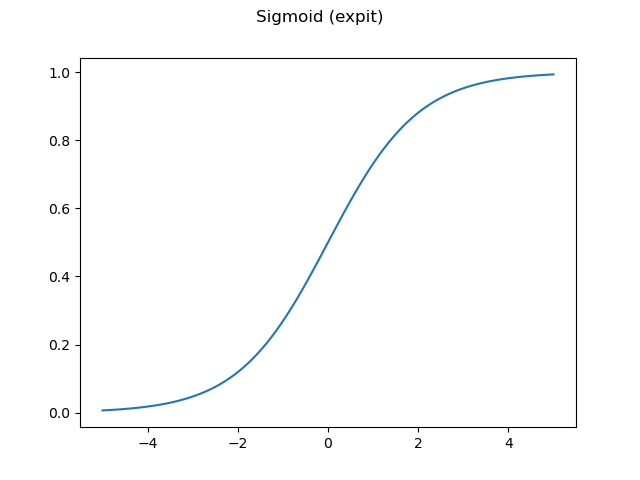

In [2]:
plt.figure()
x_grid = np.linspace(-5, 5, 100)
plt.suptitle('Sigmoid (expit)')
plt.plot(x_grid, 1/(1 + np.exp(-x_grid)))
plt.show()

<IPython.core.display.Javascript object>


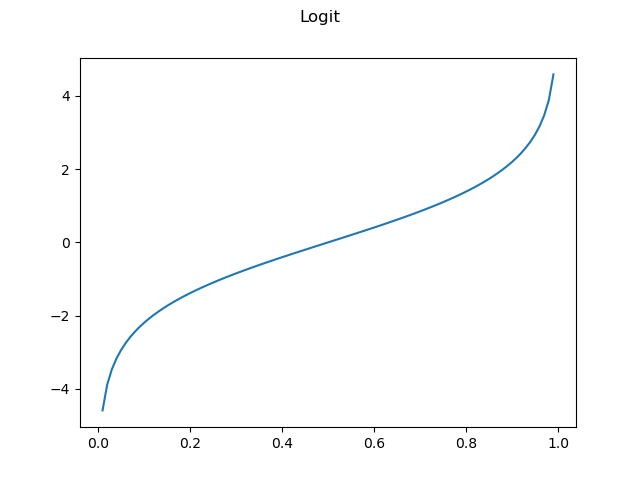

In [3]:
plt.figure()
p_grid = np.linspace(0, 1, 100)[1:-1]
plt.suptitle('Logit')
plt.plot(p_grid, np.log(p_grid / (1-p_grid)))
plt.show()

#### Sigmoid formulation of binary logistic regression
Using the sigmoid, we can reformulate both probabilities in the model as

\begin{align*}
    p_{\theta}(0 \mid x) &= \frac{1}{1 +  e^{\alpha + \beta^{\top}x}} = \sigma(-(\alpha+\beta^\top x)) = 1 - \sigma(\alpha + \beta^\top x)\\
    p_{\theta}(1 \mid x) &= \frac{e^{\alpha + \beta^{\top}x}}{1 + e^{\alpha + \beta^{\top}x}} = \sigma(\alpha + \beta^\top x),
\end{align*}
where $\sigma$ is the sigmoid function defined above. 

The last equation for the conditional success probability has a particularly nice interpretation: The argument $\alpha + \beta^{\top} x$ is just the linear hypothesis used in linear regression and the sigmoid $\sigma$ maps the result to the space $]0,1[$, which is what we need for classification. 

### Multi-class case (multinomial logistic regression)
For the multi-class case one can choose the same approach for a normalization constant as in the binary case, e.g. we can choose one particular class, say $k=0$, normalize by its probability and then drop the equation for $k=0$ from the model, i.e. work with only $K-1$ equations for $K$ classes. In this case the $\alpha_k + \beta_k^{\top}x$, $k>0$, can be interpreted as log-odds, sometimes called [*logits*](https://en.wikipedia.org/wiki/Logit). Of course instead of $k=0$, we could also choose any other $k$.

However, [popular implementations of the multi-class case](https://scikit-learn.org/stable/modules/linear_model.html#multinomial-case) choose a different approach: We keep all $K$ equations, but then normalize by taking the sum over all fitted class probabilites, i.e.
\begin{align*}
    \forall 0 \leq k \leq K-1: w_k(x; \theta) := \frac{1}{\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x}}} 
\end{align*}
In this case, all model equations can be written as
\begin{align*}
    \forall 0 \leq k \leq K-1: p_{\theta}(k \mid x) = \frac{e^{\alpha_k + \beta_k^\top x} }{\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x}}}
\end{align*}

#### Softmax formulation
The multi-class case also has a reformulation in terms of the popular [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

**Definition (softmax):** The function $\operatorname{softmax}:\mathbb{R}^K \to ]0,1[^K$ defined in every component via
\begin{align*}
    \forall 0 \leq k \leq K-1: \operatorname{softmax}_k(z) := \frac{e^{z_k}}{\sum_{l=1}^K{e^{z_l}}}
\end{align*}
is called *softmax*. 

The name stems from the fact that if you were to express the result of $\operatorname{argmax}$ as a one-hot encoding, this function can be seen as a softer approximation of that. For example, if $z=(1.2, 3.8, 2.7)$, then $\operatorname{argmax}(z)=2$, because the maximum of $z$ is attained in the second component. A one-hot encoding of that is $(0,1,0)$. The softmax of this vector is

In [4]:
z = np.array([1.2, 3.8, 2.7])
softmax(z)

array([0.05278319, 0.71065899, 0.23655783])

Consequently, we can also formulate the multi-class case in vector/softmax notation as:
\begin{align*}
    P_\theta(x) = \operatorname{softmax}(z(x)),
\end{align*}
where for any $0 \leq k \leq K-1$
\begin{align*}
    P_{\theta}(x)_k := p_{\theta}(k \mid x), && z(x)_k := \alpha_k + \beta_k^\top x.
\end{align*}

## Maximum Likelihood Estimation, Cost Function and Fit
Let $(\mathcal{X},y)=(x_i,y_i)_{i=1, \ldots, N}$ be a labelled data set and we want to fit the model to this data. Given that logistic regression is formulated in terms of log-likelihoods it is only natural to fit it via maximum likelihood estimation (MLE). Instead of maximizing the likelihood directly, we can equivalently maximize the log-likelihood, which on the diven data is simply 
\begin{align*}
    \mathcal{L}(\theta) := \sum_{i=1}^{N}{\log(p_{\theta}(y_i \mid x_i))}
\end{align*}
using the assumption that $Y_i \mid X_i$ is iid.

### Digression: Log-likelihood and Cross-Entropy
Instead of maximizing the log-likelihood, it is more common to minimize its negative, which can be written as
\begin{align*}
    J(\theta)
    := - \mathcal{L}(\theta) 
    = - \sum_{i=1}^{N}{\log(p_{\theta}(y_i \mid x_i))}
    = - \sum_{i=1}^{N}{\sum_{k=0}^{K-1}{I_{k=y_i}\log(p_{\theta}(k \mid x_i))}},
\end{align*}
where $I_{k=y_i}=1$ if $y_i=k$ and $I_{k=y_i}=0$ otherwise. Notice that if we consider all the data $y$ as a realization of a random variable $y \mid \mathcal{X}$ on $\{0, \ldots, K-1\}^N$, then $I_{k=y_i}=\hat p_i(k \mid x_i)$, where $\hat p_i$ is the pmf of the empirical distribution of that data. Hence
\begin{align*}
    J(\theta)
    = - \sum_{i=1}^{N}{\sum_{k=0}^{K-1}{\hat p_i(k \mid x_i) \log(p_{\theta}(k \mid x_i))}},
\end{align*}
which we recognize as the [*cross-entropy*](https://en.wikipedia.org/wiki/Cross-entropy) between the empirical distribution and the predicted model distribution on $\{0, \ldots, K-1\}^N$ given the data $\mathcal{X}$. For that reason, the loss function $J$ is often called the *cross-entropy loss* and we minimize this one instead of maximizing the log-likelihood.

### Binary case 
In the binary case, the cross-entropy loss has a particularly nice and prominent reformulation. Recall that in the binary case, there are only one set of parameters $\alpha:=\alpha_1$ and $\beta:=\beta_1$, hence $\theta=(\alpha,\beta)$. 

**Lemma (binary class logistic regression cost function):** If $K=2$ and the class $k=0$ is chosen to normalize the log-odds, then
\begin{align*}
    J(\theta) 
    &= -\sum_{i=1}^{N}{ y_i \log(\sigma(\alpha + \beta^\top x_i)) + (1-y_i)\log(1-\sigma(\alpha+\beta^\top x_i))} \\
    &= -\sum_{i=1}^{N}{ y_i (\alpha + \beta^\top x_i) - \log(1+e^{\alpha+\beta^\top x_i})}
\end{align*}

**Proof:** First notice that for any two real numbers $c_0, c_1 \in \mathbb{R}$ it is always true that
\begin{align*}
    \forall y \in \{0, 1\}: c_y = y c_1 + (1-y) c_0.
\end{align*}
Thus, for any $y \in \{0, 1\}$,
\begin{align*}
    \log(p_{\theta}(y \mid x))
    &= y \log(p_{\theta}(1 \mid x)) + (1-y) \log(p_{\theta}(0 \mid x)) \\
    &= y \log(\sigma(\alpha + \beta^\top x)) + (1-y)\log(1-\sigma(\alpha+\beta^\top x)),
\end{align*}
which implies the first result. To get the second equation, we set $z := \alpha + \beta^\top x$ and calculate:
\begin{align*}
    \log(\sigma(z)) & = \log \Big( \frac{1}{1+e^{-z}} \Big) = - \log(1+e^{-z}) \\
    \log(1-\sigma(t)) &= \log \Big(1- \frac{1}{1+e^{-z}} \Big) = \log \Big(\frac{e^{-z}}{1+e^{-z}} \Big) = -z - \log(1+e^{-z}) 
\end{align*}
Consequently, for any $y \in \{0,1\}$
\begin{align*}
    y \log(\sigma(z)) + (1-y)\log(1-\sigma(z)) 
    &=-y\log(1+e^{-z}) -z - \log(1+e^{-z}) + y z + y\log(1+e^{-z}) \\
    &= y z - z - \log(e^{-z}(1+e^{z})) \\
    &= y z - z + z - \log(1+e^{z}) \\
    &= y z -\log(1+e^{z}),
\end{align*}
hence the result.
\begin{array}{r}\Box\end{array}

The crucial point is that $J(\theta)$ is a non-linear equation in $\alpha,\beta$ and hence it is more difficult to solve these equations than when dealing with linear regression. We have to resort to non-linear methods like Newton-Ralphson and those require the derivative of the cost function.

**Lemma:** The derivative of the cross-entropy loss is given by
\begin{align*}
\frac{\partial J(\theta)}{\partial \alpha} 
    & = -\sum_{i=1}^{N}{ y_i - p_{\theta}(1 \mid x_i)}  \in \mathbb{R}\\
    \frac{\partial J(\theta)}{\partial \beta}
    &=-\sum_{i=1}^{N}{ x_i^\top(y_i  - p_{\theta}(1 \mid x_i)) } \in \mathbb{R}^d
\end{align*}

**Proof:** We calculate
\begin{align*}
    \frac{\partial J(\theta)}{\partial \alpha} 
    &= -\sum_{i=1}^{N}{ y_i - \frac{e^{\alpha+\beta^\top x_i}}{1+e^{\alpha+\beta^\top x_i}}}
    = -\sum_{i=1}^{N}{ y_i - p_{\theta}(1 \mid x_i)} \\
    \frac{\partial J(\theta)}{\partial \beta} 
    &=-\sum_{i=1}^{N}{ y_i x_i^\top - x_i^{\top} \frac{e^{\alpha+\beta^\top x_i}}{1+e^{\alpha+\beta^\top x_i}}} 
    =-\sum_{i=1}^{N}{ x_i^\top(y_i  - p_{\theta}(1 \mid x_i)) } \in \mathbb{R}^d
\end{align*}


### Multi class case
In the multi-class case, when we have $K$ equations, we use the analogous approach of minimizing the negative log-likelihood, i.e. the cross-entropy loss, which then has a slightly more complicated formulation, but an overall similar approach.

**Theorem (multi-class cross-entropy loss):** The cross-entropy loss in the multi-class case and its derivatives are given by
\begin{align*}
    J(\theta)
    & = - \sum_{i=1}^{N}{\alpha_{y_i} + \beta_{y_i}^\top x_i  - \log\Big(\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x_i}} \Big)} \in \mathbb{R} \\
    \frac{\partial J(\theta)}{\partial \alpha_k}
    & = - \sum_{i=1}^{N}{I_{k=y_i} - p_{\theta}(k \mid x_i) } \in \mathbb{R} \\
    \frac{\partial J(\theta)}{\partial \beta_k} 
    & = - \sum_{i=1}^{N}{x_i^\top(I_{y_i=k}   - p_{\theta}(k \mid x_i))} \in \mathbb{R}^d
\end{align*}

**Proof:** We calculate
\begin{align*}
J(\theta)
    = - \sum_{i=1}^{N}{\log(p_{\theta}(y_i \mid x_i))}
    = - \sum_{i=1}^{N}{\log\Big(\frac{e^{\alpha_{y_i} + \beta_{y_i}^\top x_i} }{\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x}}} \Big)}
    = - \sum_{i=1}^{N}{\alpha_{y_i} + \beta_{y_i}^\top x_i  - \log\Big(\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x_i}} \Big)}
\end{align*}
Therefore,
\begin{align*}
    \frac{\partial J(\theta)}{\partial \alpha_k} 
    = - \sum_{i=1}^{N}{I_{k=y_i} - \frac{e^{\alpha_k + \beta_k^\top x_i}}{\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^\top x_i}}} }
    = - \sum_{i=1}^{N}{I_{k=y_i} - p_{\theta}(k \mid x_i) },
\end{align*}
where $I_{y_i=k}:=1$ if $y_i=k$ and $I_{y_i=k}:=0$ otherwise. Analogously,
\begin{align*}
    \frac{\partial J(\theta)}{\partial \beta_k} 
    = - \sum_{i=1}^{N}{I_{y_i=k} x_i^\top  - x_i^\top \frac{e^{\alpha_k + \beta_k^{\top}}}{\sum_{l=0}^{K-1}{e^{\alpha_l + \beta_l^{\top}x_i}}}}
    =- \sum_{i=1}^{N}{x_i^\top(I_{y_i=k}   - p_{\theta}(k \mid x_i))}
\end{align*}
\begin{array}{r}\Box\end{array}

## Regularization
One can apply regularization to the cost function of logistic regression in both the binary and the multi class case just like for linear regression. In this case it is a good idea to first normalize the cost function and then add an additional term. The regularized cost function is then given by
\begin{align*}
    J_r(\theta) := \frac{1}{N} \sum_{i=1}^{n}{p_{\theta}(y_i \mid x_i)} + C^{-1} r(\theta),
\end{align*}
where $C>0$ is a parameter to tune the strength of the regularization and $r(\theta)$ is the regularization itself. There are various popular choices for the regularization, in particular
* L1: $r_1(\theta) := \|\theta\|_1$
* L2: $r_2(\theta) := \frac{1}{2}\|\theta\|_2^2$
* elastic net: $r_e(\theta) := r_1(\theta) + r_2(\theta)$.

# Example

## Binary case

In [5]:
X, y = make_classification(
    n_samples=300, 
    n_features=2,
    n_classes=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    hypercube=True,
    class_sep=2,
    random_state=3)

In [6]:
logreg = LogisticRegression(penalty=None)
logreg.fit(X, y)

LogisticRegression(penalty=None)

<IPython.core.display.Javascript object>


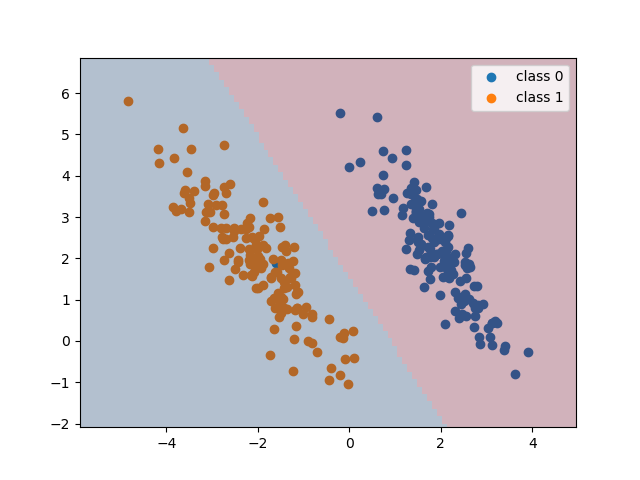

In [7]:
plt.figure()
for i in range(2):
    plt.scatter(X[y==i, 0], X[y==i, 1], label=f'class {i}')
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

### Inspection

In [8]:
# derivatives shape and value
alpha = logreg.intercept_
beta =  logreg.coef_.squeeze()
z = X @ beta + alpha
p1 = expit(z)
dJalpha = -np.sum(y - p1)
dJbeta = -np.sum(X * (y - p1)[:, np.newaxis], axis=0)
assert_equal(alpha.shape, (1,))
assert_equal(beta.shape, (2,))

assert_array_almost_equal(dJalpha, 0, decimal=4)
assert_array_almost_equal(dJbeta, 0, decimal=4)

In [9]:
# prediction
x_pred = np.array([[-0.5, 1.1],
                 [-0.2, 3.9],
                  [-4, 5]])
y_pred_proba = logreg.predict_proba(x_pred)
y_pred = logreg.predict(x_pred)

assert_array_almost_equal(y_pred_proba[:, 1],
                          expit(x_pred @ beta + alpha))

assert_equal(y_pred,
            np.argmax(y_pred_proba, axis=1))

## Multi class case

In [10]:
X, y = make_classification(
    n_samples=300, 
    n_features=2,
    n_classes=3,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    hypercube=True,
    class_sep=2,
    random_state=4)

In [11]:
logreg_multi = LogisticRegression(penalty=None)
logreg_multi.fit(X, y)

LogisticRegression(penalty=None)

<IPython.core.display.Javascript object>


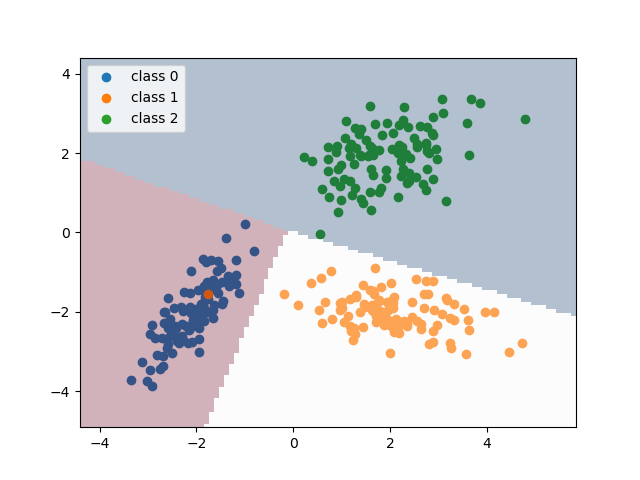

In [12]:
plt.figure()
for i in range(3):
    plt.scatter(X[y==i, 0], X[y==i, 1], label=f'class {i}')
DecisionBoundaryDisplay.from_estimator(
    logreg_multi,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

### Inspection

In [13]:
# derivatives shape and value
alpha = logreg_multi.intercept_
beta =  logreg_multi.coef_
z = np.array([X@beta[i]+alpha[i] for i in range(3)]).T
pk = softmax(z, axis=1)
Ik = np.zeros((X.shape[0], 3))
for k in range(3):
    Ik[y==k, k] = 1
dJalpha = -np.sum(Ik - pk, axis=0)
dJbeta = -np.array([np.sum(X * (Ik[:, k] - pk[:, k])[:, np.newaxis], axis=0) for k in range(k)])

assert_equal(alpha.shape, (3,))  # (n_classes)
assert_equal(beta.shape, (3, 2)) # (n_classes, n_features)
assert_array_almost_equal(dJalpha, 0, decimal=4)
assert_array_almost_equal(dJbeta, 0, decimal=4)

In [14]:
# prediction
x_pred = np.array([[-3, -0.5],
                 [1.5, -2.5],
                  [1.5, 1.5],
                  [-1, 2]])
y_pred_proba = logreg_multi.predict_proba(x_pred)
y_pred = logreg_multi.predict(x_pred)

assert_array_almost_equal(y_pred_proba,
                          softmax(np.array([beta @ x_pred[i, :] + alpha for i in range(x_pred.shape[0])]), axis=1))

assert_equal(y_pred,
            np.argmax(y_pred_proba, axis=1))

## Multi-class logistic regression vs linear regression of indicators
One might wonder why logistic regression is really needed. After all $\{0, \ldots, K-1\} \subset \mathbb{R}$, so we could just ignore the fact that the response variable $y$ has integer values and just perform a linear regression. There are multiple problems with this: 
* Just because all the data points satisfy $y_i \in \{0, \ldots, K-1\}$ doesn't mean that if we regress data $x_i$ vs. $y_i$ with some estimator $F_{\theta}$ that $F_{\theta}(x_i) \in \{0, \ldots, K-1\}$ as well, i.e. the predicted values might not be integers. Even worse, it might not even be that $F_{\theta}(x_i) \in [0, K-1]$. 
* Thinking of  $\{0, \ldots, K-1\}$ as a subset of $\mathbb{R}$ treats $y_i$ as a quantity or an order, i.e. as cardinal or ordinary cateogrical variable. If $y$ is a nomial variable, e.g. $y=0, 1, 2$ represents incomparable categories like ("car", "train", "plane"), then this is misleading.
* One can address this issue by replacing the scalar variable $y$ with a one-hot encoding $Y \in \{0, 1\}^K$ though, which is called *regression of indicators*. This results in an estimator $F_{\theta}:\mathbb{R}^d \to \mathbb{R}^K$ and we can classify any new data via
\begin{align*}
    \operatorname{argmax}_k F_{\theta}(x)
\end{align*}
Regressing indicators however, can cause another serious problem called *masking* shown next example shows. This means that one class is completely hidden from the classifier and hence this classifier is not very useful.

In [15]:
x_grid = np.linspace(-3,3, 100)
X = np.zeros((300,2))
X[:100,0] = x_grid
X[:100,1] = x_grid + np.random.normal(loc=0, scale=1, size=100)
X[100:200,0] = x_grid
X[100:200,1] = 5 + x_grid + np.random.normal(loc=0, scale=1, size=100)
X[200:300,0] = x_grid
X[200:300,1] = -5 + x_grid + np.random.normal(loc=0, scale=1, size=100)

y = np.zeros(300)
y[100:200] = 1
y[200:300] = 2

Y = np.zeros((300, 3))
Y[:100, 0] = 1
Y[100:200, 1] = 1
Y[200:300, 2] = 1

logreg_multi = LogisticRegression(penalty=None)
logreg_multi.fit(X, y)

class LinearRegressionIndicator(LinearRegression):
    
    def __init__(self):
        super().__init__(fit_intercept=True)
    
    def predict(self, x):
        return np.argmax(super().predict(x), axis=-1)
    
linreg_indicator = LinearRegressionIndicator()
linreg_indicator.fit(X, Y)

LinearRegressionIndicator()

<IPython.core.display.Javascript object>


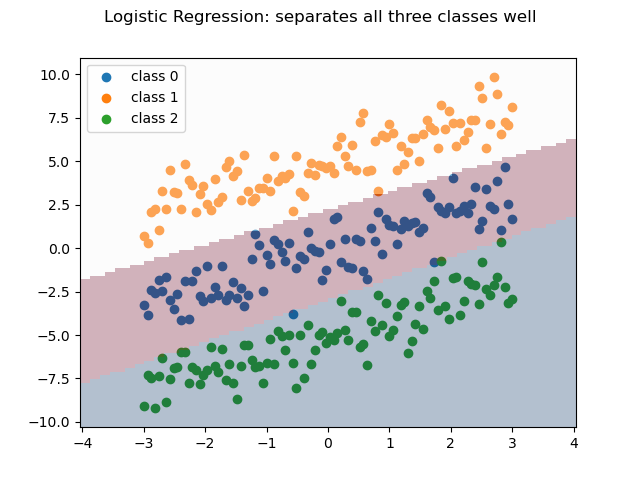

In [16]:
plt.figure()
plt.suptitle('Logistic Regression: separates all three classes well')
for i in range(3):
    plt.scatter(X[y==i, 0], X[y==i, 1], label=f'class {i}')
DecisionBoundaryDisplay.from_estimator(
    logreg_multi,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


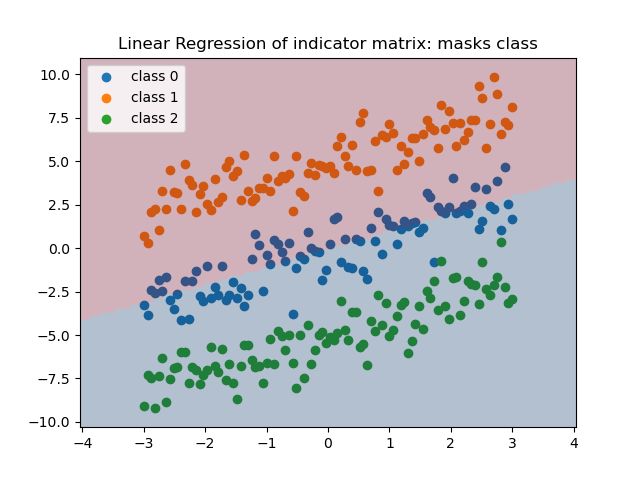

In [17]:
plt.figure()
plt.title('Linear Regression of indicator matrix: masks class')
for i in range(3):
    plt.scatter(X[y==i, 0], X[y==i, 1], label=f'class {i}')
DecisionBoundaryDisplay.from_estimator(
    linreg_indicator,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

# Sources & References
* Hastie, Tibshirani, Friedmann. *The Elements of Statistical Learning*, Chapter 4.4
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
* https://www.geeksforgeeks.org/understanding-logistic-regression/
* https://en.wikipedia.org/wiki/Cross-entropy